Data Preparation Notebook
======

Hi Merideth!  This is a step-by-step guide to the data-preparation process I underwent.  I try to do two somewhat contrary things here: I want to show you how I actually completed the steps (which is often less than the ideal way), while also illustrating what would be best to run in order to _replicate_ the work.

---

Imports: I suggest using ana/miniconda for the environment.  The command `conda create -n NAME -c conda-forge jupyter nb_conda dask pandas numpy scikit-learn fastparquet hdbscan matplotlib` will be enough to replicate everything here.  It is then activated with `source activate NAME`.

In [147]:
# Data-manipulation imports
import dask
from dask import dataframe as dd
from dask.dataframe import to_parquet, read_parquet
from dask.diagnostics import ProgressBar
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt

pbar = ProgressBar()
pbar.register()

# utilities
from multiprocessing import cpu_count
from datetime import datetime
from re import compile
from sklearn.externals.joblib import dump, load

### Cleaning/Paring [AS IT WAS DONE]

This next stretch of code is the process for turning the original download from `safecast.org` into the dataset to be used for clustering.  First, in the directory from which this notebook is launched, I assume you've run the following command(s):
```
wget https://api.safecast.org/system/measurements.tar.gz; tar -xvzf measurements.tar.gz
```
(This could take 10-15 minutes).  This should leave you with a 10+ GB `measurements-out.csv` file in the current directory.
At this stage for me, I was still operating on my laptop.  This would eventually become unwieldy and I would have to move to a cloud service.  For these steps, one would typically want a "compute-intensive" tier of machine.  The most economical version of this type of machine I saw was the 16-core compute-intensive resource from DigitalOcean at ~<span>\$</span>0.91/hr, but DigitalOcean did not have any of that type available at the specific hour I started, so I went to AWS (Amazon Web Services) instead.  While this next cell ran on my laptop, subsequent cells (until further notice) ran on a c4.8xlarge instance with 60 Gib of ram, 18 cpus of 2.9 Ghz (one thread each) at a rate of ~$1.49/hr.  I'm not sure it's worth imitating my resource use.  Even if all of these steps had executed in quick succession without hours of errors/aborted calls/memory failures, it likely was not maximally economical.  I used the Amazon Linux AMI, which I installed `git` and `miniconda` onto.  After which I created the environment with the command I recommended above.

---

In this block I read the csv in, providing dtype specifications for the `Surface` and `Radiation` columns.  They have mixed types so they need to be allowed to be read in as `object`.  I rename the `Time` column, drop the irrelevant (and mostly empty in some cases) list of columns in line 6.  I then write the repartitioned (with 24 partitions because of my 8-core machine) dataframe to parquet files (these are vastly superior, I can't recommend them enough).  The output is long (double click to reveal it) due to an error but shows that this process took ~10 minutes on a laptop.

In [9]:
# Making file more manageable by dropping undesired columns, renaming, repartitioning then saving in better file format.
# Only needed to be executed once; preserved for posterity.

mmnts = dd.read_csv('./measurements-out.csv', dtype={'Surface':'object', 'Radiation':'object'})
mmnts = mmnts.rename(columns={'Captured Time': 'Time'})
mmnts = mmnts.drop(['Device ID', 'MD5Sum', 'Height', 'Surface', 'Radiation', 'Uploaded Time', 'Loader ID'], axis=1)
ncores = cpu_count()
with ProgressBar():
    to_parquet( mmnts.repartition(npartitions=(3*ncores)), 
                '/mnt/c/users/eliw5/src/academic/Phys18Conf_1/', 
                engine='fastparquet', 
                compute=True,
    )

[                                        ] | 0% Completed | 11.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##                                      ] | 5% Completed | 31.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##                                      ] | 6% Completed | 44.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###                                     ] | 7% Completed | 48.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 10% Completed |  1min  5.0s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 12% Completed |  1min 12.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 12% Completed |  1min 13.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[######                                  ] | 16% Completed |  1min 38.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#######                                 ] | 18% Completed |  1min 51.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########                                ] | 22% Completed |  2min 13.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##########                              ] | 25% Completed |  2min 27.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##########                              ] | 26% Completed |  2min 35.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###########                             ] | 29% Completed |  2min 54.7s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###########                             ] | 29% Completed |  2min 57.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 32% Completed |  3min 16.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 33% Completed |  3min 19.7s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############                         ] | 37% Completed |  3min 42.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################                        ] | 41% Completed |  4min 11.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################                      ] | 45% Completed |  4min 34.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################                      ] | 47% Completed |  4min 43.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################                     ] | 49% Completed |  5min  0.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####################                    ] | 51% Completed |  5min  6.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[######################                  ] | 55% Completed |  5min 35.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################                ] | 62% Completed |  6min 18.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#########################               ] | 63% Completed |  6min 33.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 70% Completed |  7min  8.0s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 70% Completed |  7min  9.2s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 72% Completed |  7min 19.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############################           ] | 74% Completed |  7min 34.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 78% Completed |  7min 57.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 79% Completed |  8min  3.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#################################       ] | 83% Completed |  8min 23.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################################      ] | 85% Completed |  8min 37.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################################     ] | 87% Completed |  8min 48.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################################     ] | 88% Completed |  8min 58.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed | 10min  2.3s


Inelegantly, it took until I was over to the server to decide that I did not want to keep track of `Location Name`.  It seemed like a good idea, but it was sparse enough not to be worth the hassle in the end.  In this cell I drop that column and rewrite with more partitions (108 on my 18 core AWS instance).

In [5]:
mmnts = read_parquet('./data_files/first_trim/', engine='fastparquet')
mmnts = mmnts.drop(['Location Name'], axis='columns')
ncores = cpu_count()
mmnts = mmnts.repartition(npartitions=6*ncores)
with ProgressBar(), dask.config.set(scheduler='processes'):
    to_parquet( mmnts,
                './data_files/second_trim/',
                engine='fastparquet',
                compute=True
    )

[########################################] | 100% Completed |  1hr  3min  1.6s


Now lacking the sparse `Location Name` column, it was easy to `dropna` across all columns, since any sample lacking a `Time`, `Latitude`, `Longitude`, `Value`, or `Unit` was useless.  This step was surprisingly quick.

In [8]:
mmnts = read_parquet('./data_files/second_trim/', engine='fastparquet')
mmnts = mmnts.dropna()
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
                './data_files/third_trim/',
                engine='fastparquet',
                compute=True
    )

[########################################] | 100% Completed | 49.6s


In this cell, I made the `Unit` column have the `category` dtype.  Dask dataframes have a built in `.categorize` method.  Initially, I resisted using this just as an animal spirit, and instead separated the `Unit` column, called `.astype('category').to_frame()`, and attempted to re-`merge` them.  This was a disastrous idea.  If it all possible, it is crucial to avoid `merge` on anything of size using Dask (and this dataset had 110 million entries when *I* downloaded it).  The best answer I saw in my troubleshooting (I didn't investigate the source) was that Dask inefficiently tries to build the entire merged dataframe in memory.  This would result in fully duplicating the whole 110 million entries, which could be significantly bigger in-memory than they appear as parquet files (where they total 5.6 GB).  Just this `merge` was capable of consuming more than 60 Gib (64 GB) of RAM.  Additionally, if Dask does not remember that, despite being separated, the dataframes have all the same partitions, it could cause a linear-time search for each sample across every partition of the merging dataframe.  I'm sure there are more detailed reasons for the failure.  The several, hour-long eventual failed steps have _not_ been kept here for posterity.

In [3]:
mmnts = read_parquet('./data_files/third_trim/', engine='fastparquet')
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts.categorize(columns=['Unit'], index=False),
                '/home/ec2-user/Phys18Conf_1/data_files/fourth_trim/',
                engine='fastparquet',
                compute=True,
    )

[########################################] | 100% Completed | 20.3s
[########################################] | 100% Completed | 18.5s


This cell contains the most substantive transformation so far: changing the Python object time-stamp strings into numbers of seconds since 2011 (a month or two before the first datum).  This will later be necessary so that DBSCAN can do its temporal clustering with a readable value.  Once again motivated by avoiding `dask.DataFrame.merge` at all costs, we find a way to, in parallel and without changing/splitting the dataframe, apply the desired transformation only to the `Time` column entries.  We do this by mapping to each partition (`.map_partitions`) a `lambda`, that calls `pandas.DataFrame.apply`, _column-wise_ with the function `filt`.  `filt` checks if the column has `dtype == 'object` (as only the `Time` column will).  If so, it calls `pandas.Series.apply` on the _column_ (always the `Time` column in practice) with `tconv`, which reads the string into a Python `datetime` object; takes its difference from 2011 as a `time_delta`; then converts that to seconds as an numpy `int64`.  There are three levels of `apply` going on here!

In [9]:
start_dt = datetime.strptime('2011-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
microseconds = compile('\.\d*')

def filt(col):
    if col.dtype != 'object':
        return col
    else:
        return col.apply(tconv)
    
def tconv(s):
    dt = datetime.strptime(microseconds.sub('', str(s)), '%Y-%m-%d %H:%M:%S')
    delta = dt - start_dt
    result = np.array(delta.total_seconds())
    return result.astype(np.int64)

mmnts = read_parquet('./data_files/fourth_trim/', engine='fastparquet')
_meta = {'Time': 'int64', 'Latitude': 'float64', 'Longitude': 'float64', 'Value': 'float64', 'Unit': 'category'}
mmnts = mmnts.map_partitions(lambda df: df.apply(filt, axis=0), meta=_meta)
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
               '/home/ec2-user/Phys18Conf_1/data_files/fifth_trim',
               engine='fastparquet',
               compute=True
    )

[########################################] | 100% Completed |  1min 56.6s


For comparison, the dataframe has just about 110 million rows before we drop the inappropriate units.  After, it would have about 102 million.

In [13]:
len(mmnts)

109799687

Here we see the distribution of values across the categories of `Unit`.  The vast majority are CPMs.  We would maintain almost all the data by only taking the rows of category `cpm`.  A number of units are totally uninterpretable/unusable.  `status` is not any kind of unit as far as I can tell. (Perhaps it is a default that people forget to change when submitting their observations?).  Perhaps there is some way to measure radiation as a temperature, but I couldn't find any evidence of `celcius` as a unit of radiation.  `1`, `0`, `DeviceType1`, `DeviceType2` are not units at all.  From brief investigation, it appears that `PM1`, `PM2.5`, `PM10`, `pm2.5` are a type of air quality measure.  This is probably because SafeCast is trying to break into other kinds of environmental monitoring, including air quality.  This also appears to be the source of `NOXppm` and `HUMD%`.  `RSSI` is a measure of radio signal strength.  `TEMPC`, perhaps another temperature measurement.  The only reputable alternative measurement present is the Sievert.  I looked into converting the sievert measurements to CPMs, but it appears that _how_ to do this conversion depends on what atomic substance the Geiger counter was calibrated with: CPMs translate differently to Sieverts calibrated with Cobalt isotope than with Caesium isotope.  This information was not present even in the full table, so this ruled out the conversion.  Unfortunately, the largest chunks left on the table were not the Sieverts, but the unsalvageable `status` and the `celcius`.  

In [20]:
mmnts = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/fifth_trim/', engine='fastparquet')
with ProgressBar():
    out = mmnts['Unit'].value_counts().compute(scheduler='processes', optimize_graph=True)

[########################################] | 100% Completed |  0.7s


In [21]:
out

cpm             102927743
status            3765116
celcius           2775932
usv                279888
microsievert        30096
 cpm                10043
1                    8892
DeviceType2          1363
CPM                   289
Cpm                    55
DeviceType1            45
usv/hr                 43
uSv/h                  43
PM1                    28
HUMD%                  20
PM2.5                  17
0                      15
uSv                    14
PM10                   13
NOXppm                 12
TEMPC                  11
pm2.5                   4
uSv/hr                  3
RSSI                    2
Name: Unit, dtype: int64

Nonetheless, we could retain the ~11,000 measurements separated only by the alternate spellings of CPM.  Now that all units were CPM, we could discard the `Unit` column entirely.  `out2[:-2]` merely gets rid of two rows with bad time stamps (instead of 2011 they read 201).  This wasn't done earlier because `dask.DataFrame.drop` does not support dropping rows.  

In [23]:
with ProgressBar():
    out2 = mmnts[mmnts['Unit'].isin(['cpm', ' cpm', 'CPM', 'Cpm'])].compute(scheduler='processes', optimize_graph=True)

[########################################] | 100% Completed | 36.4s


In [43]:
out2

,Time,Latitude,Longitude,Value
0,286909200,37.507552,139.941170,72.0
1,286887600,37.507250,139.940000,55.0
2,286887600,37.505445,0.016667,68.0
3,286686000,34.066487,-118.895217,50.0
4,286678800,37.673233,140.066667,48.0
5,286678800,37.674782,140.079895,52.0
6,285015600,37.517902,139.925478,59.0
7,285015600,37.754973,140.687660,384.0
8,285015600,37.526595,139.931667,59.0
9,285015600,37.737157,140.726832,441.0


In [42]:
out2.drop('Unit', axis=1, inplace=True)
out3 = dd.from_pandas(out2[:-2], npartitions=108)
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( out3,
                '/home/ec2-user/Phys18Conf_1/data_files/sixth_trim/',
                engine='fastparquet',
                compute=True,
    )

[########################################] | 100% Completed | 16.4s


### Cleaning/Paring [AS IT SHOULD BE DONE]

---

This cell, as long as the initial csv was read validly from a file system, and written back as parquet files validly to a file system, would complete all the above transformations in a single step. 

Using the `usecols` keyword argument, only the five columns of interest are read in from the original csv.  Renaming, repartitioning, dropping NaNs, categorizing, and numerifying of the `Time` column are all done before calling `.compute`.  The categories which are typographical variations on CPM are automatically identified and those rows agglomerated before `Unit` is dropped.   `Time` is numerified after these steps so that observations which will not be used are never converted.  I also realized that you can simply reassign a column within a dataframe without a merge--oops!  We compute the dataframe before writing it back because it _seems_ to be the only way to drop the last two rows with messed-up time stamps.  If it was possible to `.concat` a dask dataframe with a pandas dataframe then I might try to compute only the last partition to drop the rows.  But since there is not, it seems there is no getting around calling `.compute` on the entire dataframe.    

In [ ]:
mmnts = dd.read_csv('measurements-out.csv', usecols=['Captured Time', 'Latitude', 'Longitude', 'Value', 'Unit'])
mmnts = mmnts.rename(columns={'Captured Time': 'Time'})
mmnts = mmnts.repartition(npartitions=(6*cpu_count()))
mmnts = mmnts.dropna()
with dask.config.set(scheduler='processes'):
    mmnts = mmnts.categorize(columns=['Unit'], index=False)
cpms = []
for category in mmnts['Unit'].cat.categories:
    if category.lower().strip() == 'cpm':
        cpms.append(category)
mmnts = mmnts[mmnts['Unit'].isin(cpms)]

start_dt = datetime.strptime('2011-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
microseconds = compile('\.\d*')

def tconv(s):
    dt = datetime.strptime(microseconds.sub('', str(s)), '%Y-%m-%d %H:%M:%S')
    delta = dt - start_dt
    result = np.array(delta.total_seconds())
    return result.astype(np.int64)

mmnts['Time'] = mmnts['Time'].apply(tconv, axis=1, meta=('Time', 'int64'))
mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
mmnts = dd.from_pandas(mmnts_out[:-2], npartitions=(6*cpu_count()))
with dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
                '/path/to/your/storage/location/',
                engine='fastparquet',
                compression='snappy'
                compute=True,
    )

### Clustering [AS IT WAS DONE]

---

This step required a couple iterations.  Initially, I tried to run a clustering algorithm on all 102 million points.  I investigated a number of algorithms, and delved into a package called `hdbscan` which was supposed to be a, quality-, time- (I'm don't know if memory-) improvement on DBSCAN.  However, after hdbscan didn't finish for several hours, I looked into the benchmarking in the [hdbscan documentation](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html).  Though hdbscan is a better performer than sklearn.cluster.DBSCAN, both curve upward (neither are linear in time) and begin reaching a minute of computation after only 200,000 points (albeit on a slightly less powerful machine).  If it scaled linearly, this would still require `100,000,000/(200,000*60) = 8.33` hours, but it is certainly significantly worse.  I realized no clustering algorithm that I could conveniently reach from Python without a huge rewrite was going to cluster this many points successfully--that was out of reach.  But I knew that many of the points were nowhere near each other (separated by oceans); perhaps the clustering was feasible in smaller bins.  Initially, I invested significant time in attempting to _visualize_ all the points in order to see where to draw these boundaries.  This was another costly and unsuccessful detour.  There was no library which both supported visualization of this many points _and_ would respect a coordinate reference system.  Several libraries, including `datashader`, `geoviews`, and `holoviews`, made claims, but none of their documentation (which was all jupyter notebooks which demonstrated only very particular use cases) demonstrated this functionality.  They all ran code that was oblivious to any coordinate reference system, and none on a global scale.

Ultimately, I binned the points by hand using the somewhat primitive heat map at `safecast.org/tilemap/`, this image: 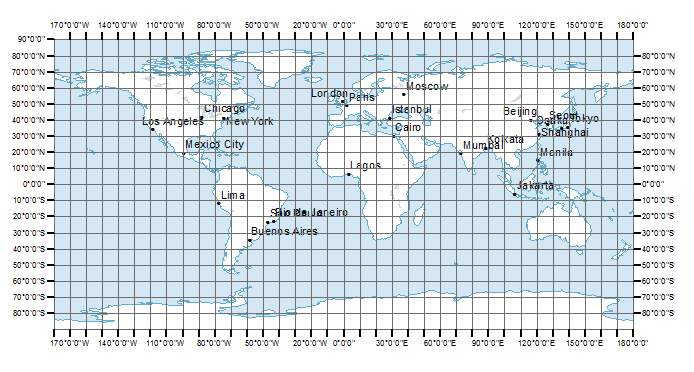 and Google Earth.  The block below iteratively selects for the points within the chosen regions, then subtracts them from the remainder `rem`.  Ultimately, the dataset was divided into a North America, South America, Africa, Japan and South Korea, Australia, and "everywhere else" group, whose numbers are displayed in the cell below.  

(Apologies for the formatting: Pandas' Boolean filtering syntax not only requires that `and` be `&` and `or` be `|`, but also that nothing is chained and all parentheses are painfully explicit.  The assignments come in pairs because each convoluted Boolean filter must be negated in order to filter the previously assigned entries from `rem`.)

In [8]:
#mmnts         = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/sixth_trim', engine='fastparquet')
rem           = mmnts.compute(scheduler='processes', optimize_graph=True)
rem.rename(columns={'Time':'time', 'Latitude':'lat', 'Longitude':'lon', 'Value':'val'}, inplace=True)

north_america = rem[((rem['lon'] < -40) | (rem['lon'] > 160)) 
                      & 
                    (rem['lat'] > 15)]

rem           = rem[~(((rem['lon'] < -40) | (rem['lon'] > 160)) 
                      & 
                    (rem['lat'] > 15))]

south_america = rem[((-90 < rem['lon']) & (rem['lon'] < -25)) 
                      & 
                    ((-60 < rem['lat']) & (rem['lat'] < 15))]

rem           = rem[~(((-90 < rem['lon']) & (rem['lon'] < -25)) 
                      & 
                    ((-60 < rem['lat']) & (rem['lat'] < 15)))]

# dropping fukushima meltdown
before = len(rem)
rem           = rem[~(((36.58 < rem['lat']) & (rem['lat'] < 38.083)) 
                      & 
                    ((138.75 < rem['lon']) & (rem['lon'] < 141.25)))]
after = len(rem)
discarded = before - after

japan_korea   = rem[((28.876 < rem['lat']) & (rem['lat'] < 47.46)) 
                      & 
                    ((117.675 < rem['lon']) & (rem['lon'] < 160))]

rem           = rem[~(((28.876 < rem['lat']) & (rem['lat'] < 47.46)) 
                      & 
                    ((117.675 < rem['lon']) & (rem['lon'] < 160)))]

australia     = rem[((-50 < rem['lat']) & (rem['lat'] < -10)) 
                      & 
                    ((105 < rem['lon']) & (rem['lon'] < 160))]

rem           = rem[~(((-50 < rem['lat']) & (rem['lat'] < -10)) 
                      & 
                    ((105 < rem['lon']) & (rem['lon'] < 160)))]

w_europe      = rem[((18.5 < rem['lat']) & (rem['lat'] < 72.5)) 
                      & 
                    ((-30 < rem['lon']) & (rem['lon'] < 44))]

rem           = rem[~(((18.5 < rem['lat']) & (rem['lat'] < 72.5)) 
                      & 
                    ((-30 < rem['lon']) & (rem['lon'] < 44)))]

africa        = rem[((-40 < rem['lat']) & (rem['lat'] < 11)) 
                      & 
                    ((-25 < rem['lon']) & (rem['lon'] < 60))]

rem           = rem[~(((-40 < rem['lat']) & (rem['lat'] < 11)) 
                      & 
                    ((-25 < rem['lon']) & (rem['lon'] < 60)))]

elsewhere     = rem

[########################################] | 100% Completed | 23.2s


In [10]:
sum = len(north_america)+len(south_america)+len(japan_korea)+len(australia)+len(w_europe)+len(africa)+len(elsewhere)+discarded
print("Point Distribution among Regions:\n")
print("North America:                   " + str(len(north_america)))
print("South America:                   " + str(len(south_america)))
print("Japan and South Korea:           " + str(len(japan_korea)))
print("Australia:                       " + str(len(australia)))
print("Western Europe:                  " + str(len(w_europe)))
print("(Most of) Africa:                " + str(len(africa)))
print("Proximate to Fukushima Meltdown: " + str(discarded))
print("Everywhere else:                 " + str(len(elsewhere)))
print("Total:                           " + str(sum) + "\n")
print(\
'''
Subtracting the points proximate to the Fukushima meltdown, we are left with 
 
                             ''' + str(sum - discarded))

Point Distribution among Regions:

North America:                   20020113
South America:                   289636
Japan and South Korea:           31819071
Australia:                       1396507
Western Europe:                  24888188
(Most of) Africa:                832130
Proximate to Fukushima Meltdown: 18747474
Everywhere else:                 4945011
Total:                           102938130


Subtracting the points proximate to the Fukushima meltdown, we are left with 
 
                             84190656


In [14]:
with dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( dd.from_pandas(north_america, npartitions=18), 
                '/home/ec2-user/Phys18Conf_1/data_files/split/north-america/',
                compute=True,
              )
    south_america.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/south-america/south-america.parquet',
                             engine='fastparquet',
                             compression=None)
    to_parquet( dd.from_pandas(japan_korea, npartitions=36), 
                '/home/ec2-user/Phys18Conf_1/data_files/split/japan-korea/',
                compute=True,
              )
    to_parquet( dd.from_pandas(australia, npartitions=2),
                '/home/ec2-user/Phys18Conf_1/data_files/split/australia/',
                compute=True,
              )
    to_parquet( dd.from_pandas(w_europe, npartitions=27),
                '/home/ec2-user/Phys18Conf_1/data_files/split/western-europe/',
                compute=True
              )
    africa.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/africa/africa.parquet',
                      engine='fastparquet',
                      compression=None)
    to_parquet( dd.from_pandas(elsewhere, npartitions=6),
                '/home/ec2-user/Phys18Conf_1/data_files/split/elsewhere/',
                compute=True,
              )

[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  1.4s


Believing `hdbscan.HDBSCAN` to be slow from my prior experience, I tried `sklearn.cluster.DBSCAN` instead.  To my pleasant surprise, although `DBSCAN` utilized closer to 50% of my CPU while `HDBSCAN` utilized closer to 10%, `HDBSCAN` finished much faster: `DBSCAN` took 8-10 minutes (I forgot to time it exactly) while `HDBSCAN` took only 2:15!

In [12]:
south_america = pd.read_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/south-america/south-america.parquet', engine='fastparquet')
south_america_clusterer = DBSCAN(eps=8.04672/6371., min_samples=15, metric='haversine', algorithm='ball_tree', n_jobs=-1)
south_america_clusterer.fit(np.radians(south_america[['lat', 'lon']].values))
dump(south_america_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-clustering-1.pkl')

['/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-clustering-1.pkl']

In [14]:
%%time
south_america_hdbscan_trial = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=-1)
south_america_hdbscan_trial.fit(np.radians(south_america[['lat', 'lon']].values))
dump(south_america_hdbscan_trial, '/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-hdbscan-test-2.pkl')

/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 2min 5s


More importantly, hdbscan clustered better.  As can be seen by inspecting the full cluster enumerations (`cluster_label: cluster_size`) and descriptive statistics below, hdbscan produced far more numerous (801 versus dbscan's 85!) and more consistently sized clusters (a `cluster_label` of `-1` indicates a noise point):

In [25]:
# DBSCAN - CLUSTERS
unique, counts = np.unique(south_america_clusterer.labels_, return_counts=True)
dict(zip(unique, counts))    

{-1: 12607,
 0: 2782,
 1: 3910,
 2: 3220,
 3: 3994,
 4: 35801,
 5: 113,
 6: 85,
 7: 156,
 8: 65,
 9: 113,
 10: 108,
 11: 22,
 12: 13136,
 13: 370,
 14: 49,
 15: 27,
 16: 24,
 17: 65,
 18: 60,
 19: 18,
 20: 60,
 21: 63,
 22: 24310,
 23: 10685,
 24: 17315,
 25: 13761,
 26: 1491,
 27: 7533,
 28: 7501,
 29: 16379,
 30: 2694,
 31: 43,
 32: 87,
 33: 15,
 34: 21583,
 35: 8284,
 36: 3643,
 37: 19169,
 38: 820,
 39: 23899,
 40: 5869,
 41: 180,
 42: 146,
 43: 25,
 44: 18,
 45: 22,
 46: 21,
 47: 26,
 48: 11,
 49: 27,
 50: 28,
 51: 26,
 52: 25,
 53: 27,
 54: 18,
 55: 27,
 56: 28,
 57: 28,
 58: 18,
 59: 28,
 60: 16,
 61: 28,
 62: 19,
 63: 24,
 64: 15,
 65: 16,
 66: 46,
 67: 27,
 68: 18,
 69: 27,
 70: 21,
 71: 26,
 72: 27,
 73: 28,
 74: 29,
 75: 27,
 76: 52,
 77: 26,
 78: 18,
 79: 28,
 80: 28,
 81: 6205,
 82: 7486,
 83: 848,
 84: 10837,
 85: 1056}

In [27]:
# DBSCAN - MEAN AND MEDIAN CLUSTER SIZE
print('Mean:   ' + str(np.mean(counts)))
print('Median: ' + str(np.median(counts)))

Mean:   3329.1494252873563
Median: 49.0


In [28]:
# HDBSCAN - CLUSTERS
unique, counts = np.unique(south_america_hdbscan_trial.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 56517,
 0: 1491,
 1: 2120,
 2: 271,
 3: 1876,
 4: 245,
 5: 125,
 6: 411,
 7: 132,
 8: 397,
 9: 236,
 10: 563,
 11: 151,
 12: 307,
 13: 289,
 14: 698,
 15: 140,
 16: 1196,
 17: 397,
 18: 855,
 19: 103,
 20: 557,
 21: 267,
 22: 256,
 23: 264,
 24: 371,
 25: 204,
 26: 200,
 27: 217,
 28: 727,
 29: 375,
 30: 161,
 31: 293,
 32: 112,
 33: 331,
 34: 212,
 35: 193,
 36: 111,
 37: 105,
 38: 274,
 39: 109,
 40: 208,
 41: 406,
 42: 253,
 43: 256,
 44: 362,
 45: 331,
 46: 405,
 47: 277,
 48: 229,
 49: 162,
 50: 175,
 51: 126,
 52: 224,
 53: 369,
 54: 417,
 55: 120,
 56: 374,
 57: 185,
 58: 168,
 59: 254,
 60: 163,
 61: 907,
 62: 103,
 63: 118,
 64: 247,
 65: 168,
 66: 338,
 67: 345,
 68: 187,
 69: 186,
 70: 295,
 71: 152,
 72: 258,
 73: 285,
 74: 199,
 75: 247,
 76: 187,
 77: 123,
 78: 139,
 79: 227,
 80: 469,
 81: 148,
 82: 133,
 83: 119,
 84: 154,
 85: 442,
 86: 208,
 87: 109,
 88: 112,
 89: 105,
 90: 264,
 91: 288,
 92: 206,
 93: 149,
 94: 305,
 95: 312,
 96: 131,
 97: 129,
 98: 113,
 99:

In [29]:
# HDBSCAN - MEAN AND MEDIAN CLUSTER SIZE
print('Mean:   ' + str(np.mean(counts)))
print('Median: ' + str(np.median(counts)))

Mean:   360.69240348692404
Median: 223.0


The fitted HDBSCAN object gives us two values for each observation: the cluster that the entry belongs to (`label`) and the  probability of its membership in that cluster (`prob`).  I first join these two columns to the `south_america` dataframe and drop the noise points; this removes `289636 - 233119 = 56517` points:

In [140]:
south_america_cluster_data = pd.DataFrame({'label':south_america_hdbscan_trial.labels_, 'prob':south_america_hdbscan_trial.probabilities_})
south_america.reset_index(drop=True, inplace=True)
south_america_plus = south_america.join(south_america_cluster_data, how='inner')
south_america_plus = south_america_plus[south_america_plus['label'] != -1]
len(south_america_plus)

233119

I then sort the values by decreasing probability and convert the `prob` column's values to the value of each row's cumulative sum divided by the total sum (normalization).   

In [141]:
total = south_america_plus['prob'].sum()
south_america_plus.sort_values(by='prob', ascending=False, inplace=True)
south_america_plus.loc[:, 'prob'] = south_america_plus['prob'].cumsum()
south_america_plus.loc[:, 'prob'] = south_america_plus['prob'] / total

The density plot below then shows that most values contribute equally (the central plateau); the contribution begins to decline at 75% of the total probability; and the dense area of negligible probability really spikes after about 90% of total probability mass has been accumulated:

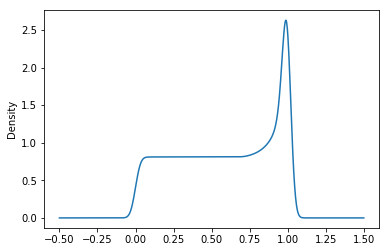

In [151]:
%matplotlib inline
south_america_plus['prob'].plot(kind='density')

This is why our first step below is to filter out rows with a cumulative probability of 90% or more.  The subsequent steps serve to provide a geographic perspective on how much area each of these cells actually covers.  The median value is exceptionally targeted: at the equator where latitudes and longitudes are each roughly 69 miles each, a `0.007*0.008` area is just under 0.3 square miles.  (This only gets smaller as one travels to the poles).  These median values are, however, significantly smaller than the average, which by the same calculation covers up ~128 square miles at the equator.  (Fun fact, the major American cities with a land area closest to 128 sq. miles in descending order are Lynchburg, Tennessee, Omaha, Nebraska, and my home town, Greensboro, North Carolina!).  

In [155]:
south_america_plus = south_america_plus[south_america_plus['prob'] < 0.9]
lat_sum, lon_sum = 0, 0
num_labels = south_america_plus['label'].max() + 1
for i in range(num_labels):
    df = south_america_plus[south_america_plus['label'] == i]
    lat_sum += abs(df['lat'].max() - df['lat'].min())
    lon_sum += abs(df['lon'].max() - df['lon'].min())
lat_avg = lat_sum / num_labels
lon_avg = lon_sum / num_labels
print('Average latitudinal span:  ' + str(lat_avg))
print('Average longitudinal span: ' + str(lon_avg))

Average latitudinal span:  0.19990640482127803
Average longitudinal span: 0.13334443474646707


In [3]:
lats, lons = [], []
for i in range(num_labels):
    df = south_america_plus[south_america_plus['label'] == i]
    lats.append(abs(df['lat'].max() - df['lat'].min()))
    lons.append(abs(df['lon'].max() - df['lon'].min()))
lats = np.array(lats)
lons = np.array(lons)
print('Median latitudinal span:  ' + str(np.median(lats)))
print('Median longitudinal span: ' + str(np.median(lons)))
south_america_plus.drop(columns='prob', inplace=True)
south_america_plus.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/south_america_spatial/south-america.parquet',
                              engine='fastparquet', compression=None)

Median latitudinal span:  0.007248333333301105
Median longitudinal span: 0.008310000000001594


Next I go to investigate the time spread of the clusters.  As can be seen in the plot, the vast majority of them cover only a fraction of a day.  In fact, one can be quite certain that many clusters in this region are just a single device submitting a large number of observations in sequence.  These are not necessarily useful to us.  We focus instead on the oddly consistent stretch of clusters with a time range between 190 and 260 days.  (This is the small bump immediately to the right of the largest spike in the plot below).  

In [14]:
sa_plus = pd.read_parquet('/home/ec2-user/Phys18Conf_1/data_files/south_america_spatial/south-america.parquet',
                                     engine='fastparquet')
num_labels = sa_plus['label'].max() + 1
clusters, timespans = {}, {}
name = "sa_%s"
for i in range(num_labels):
    clusters[name % i]  = sa_plus[sa_plus['label'] == i]
    timespans[name % i] = ((clusters[name % i]['time'].max() - clusters[name % i]['time'].min()) / 86400) 

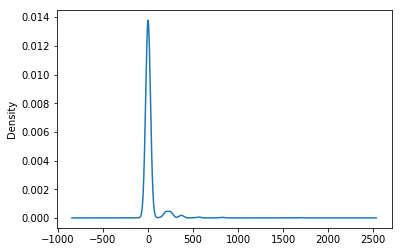

In [44]:
tspan = pd.Series(list(timespans.values()), index=list(timespans.keys()))
tspan.plot(kind='density')

In [228]:
tspan.sort_values(ascending=False, inplace=True)
sel = tspan[(tspan > 190) & (tspan < 300)]
to_plot = list(sel.index)
to_plot.reverse()

In [218]:
sel

sa_339    252.830417
sa_476    252.746782
sa_776    252.316262
sa_775    252.316030
sa_756    252.264097
sa_768    252.210903
sa_772    252.030590
sa_771    252.023866
sa_542    252.005220
sa_646    252.003576
sa_593    250.771366
sa_592    250.765197
sa_150    250.736169
sa_158    250.724086
sa_157    250.705891
sa_585    250.686065
sa_586    250.678565
sa_607    250.670845
sa_606    250.661609
sa_556    250.632859
sa_622    250.600961
sa_736    196.301678
sa_737    196.290289
sa_738    196.282639
sa_716    196.271250
sa_678    196.234282
sa_683    196.216470
sa_704    196.206551
sa_705    196.203090
sa_667    196.199248
sa_637    196.190417
sa_636    196.180787
sa_629    196.175000
sa_630    196.171678
sa_571    196.159699
sa_446    196.149664
sa_493    196.125532
sa_564    196.113681
sa_587    196.099074
sa_611    196.093299
sa_734    196.043426
sa_295    196.005012
dtype: float64

We see that these groups, despite being longer lasting, remain quite small:

In [94]:
dxs, dys = [], []
for df in to_plot:
    dx = abs(clusters[df]['lat'].max() - clusters[df]['lat'].min())
    dy = abs(clusters[df]['lon'].max() - clusters[df]['lon'].min())
    dxs.append(dx)
    dys.append(dy)
    print("{} -- deltaLat: {:<22} | deltaLon: {:<22} | area: {:<22}".format(df, dx, dy, dx*dy))
_dxs = np.array(dxs)
_dys = np.array(dys)

sa_295 -- deltaLat: 0.012720000000001619   | deltaLon: 0.012725000000003206   | area: 0.00016186200000006137
sa_734 -- deltaLat: 0.0001216666666046251  | deltaLon: 7.500000000248974e-05  | area: 9.124999995649802e-09 
sa_611 -- deltaLat: 0.0064583333333025905  | deltaLon: 0.005778333333296359   | area: 3.731840277736135e-05 
sa_587 -- deltaLat: 0.0016833333333998723  | deltaLon: 0.008708333333302676   | area: 1.4659027778305614e-05
sa_564 -- deltaLat: 0.03303666666669969    | deltaLon: 0.008021666666600424   | area: 0.0002650091277758542 
sa_493 -- deltaLat: 0.013659999999998007   | deltaLon: 0.019978333333398268   | area: 0.00027290403333418055
sa_446 -- deltaLat: 0.02187166666669782    | deltaLon: 0.032898333333299945   | area: 0.0007195413805558502 
sa_571 -- deltaLat: 0.028306666666605196   | deltaLon: 0.027965000000001794   | area: 0.0007915959333316651 
sa_630 -- deltaLat: 0.08036000000000243    | deltaLon: 0.026778333333297155   | area: 0.0021519068666638243 
sa_629 -- deltaLat:

In [95]:
print("Mean deltaLat:                  " + str(_dxs.mean()))
print("Median deltaLat:                " + str(np.median(_dxs)))
print("Standard deviation of deltaLat: " + str(np.std(_dxs)))
print()
print("Mean deltaLon:                  " + str(_dys.mean()))
print("Median deltaLon:                " + str(np.median(_dys)))
print("Standard deviation of deltaLon: " + str(np.std(_dys)))

Mean deltaLat:                  0.016586706349202705
Median deltaLat:                0.010580833333349027
Standard deviation of deltaLat: 0.024562553201439016

Mean deltaLon:                  0.0155655952380889
Median deltaLon:                0.01045333333339471
Standard deviation of deltaLon: 0.01807857013129727


We next look at the densities in order to see how consistent these clusters are as time series.  The consistent bimodality is quite strange, although I realized later that with even the highest peaks having such low density (in the hundredths), the plots are perhaps a bit misleading.  However, on this initial intuition, I painstakingly cut each plot down the middle

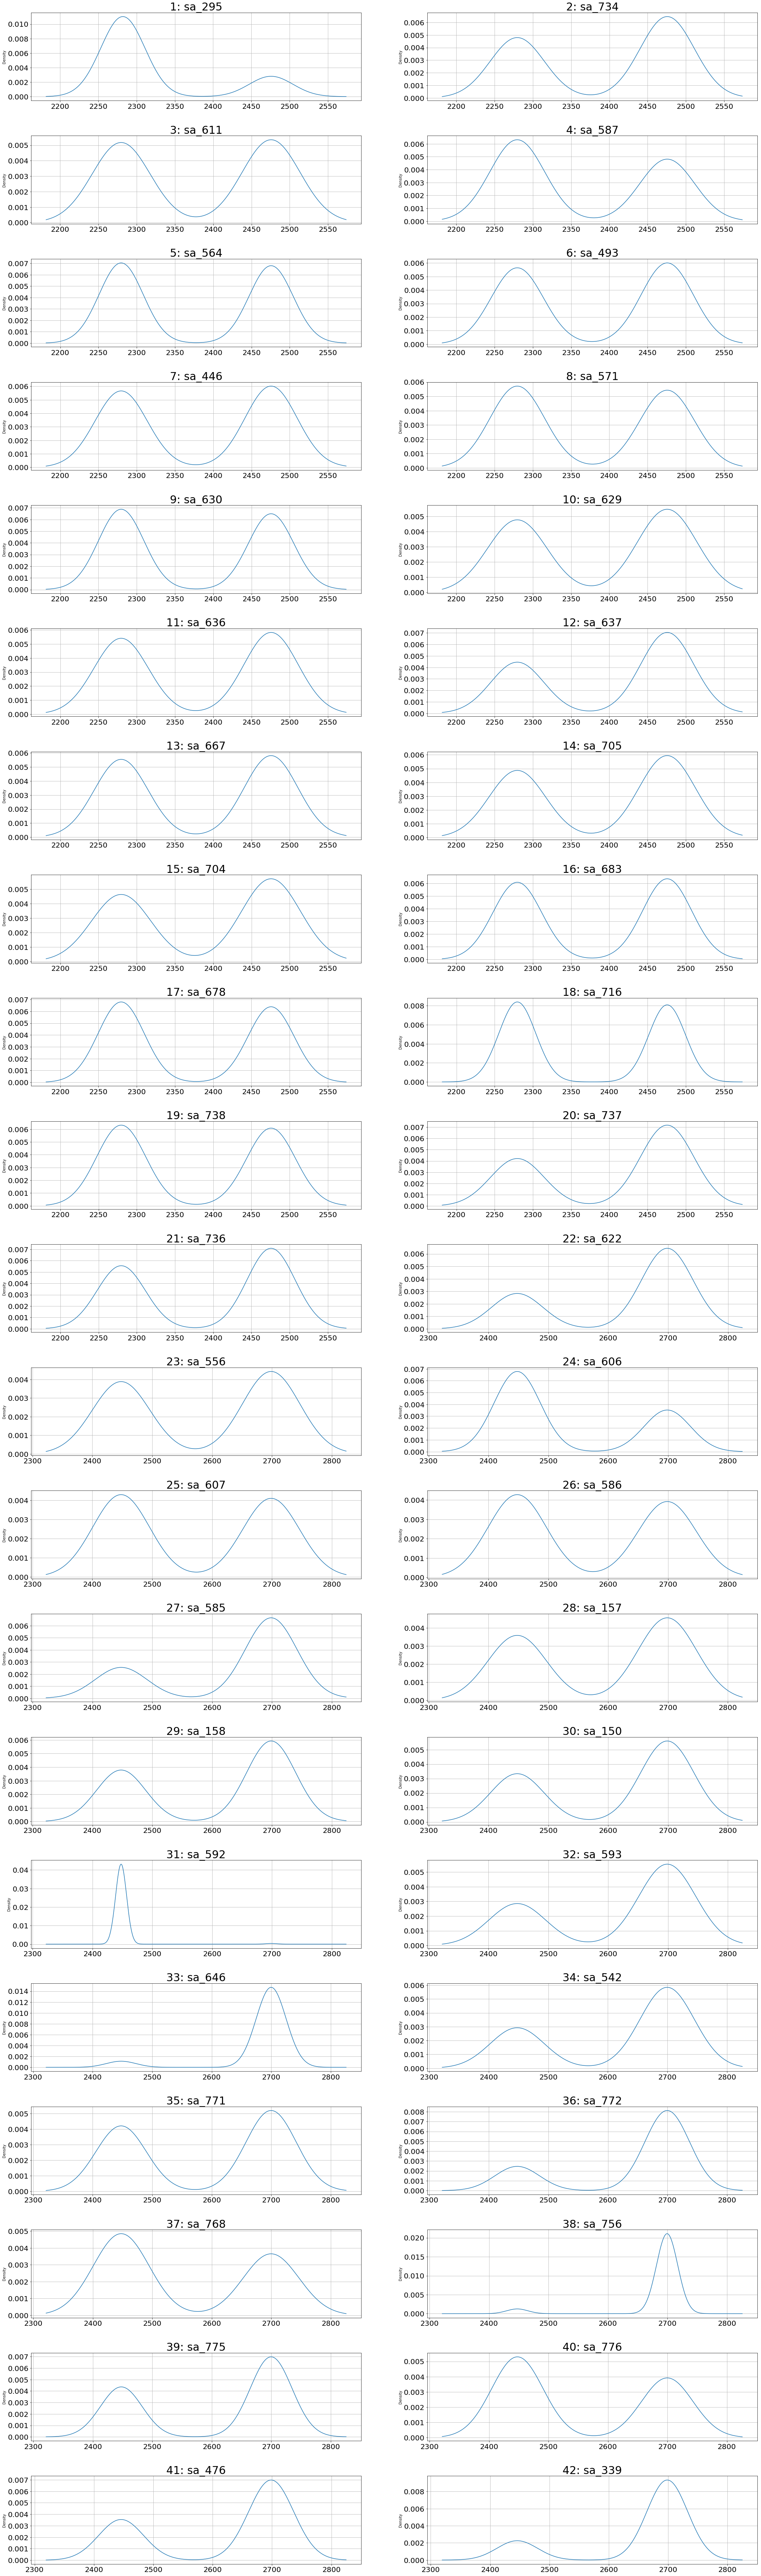

In [226]:
sel_clusters = {key: val for key, val in clusters.items() if key in list(sel.index)}
fig, axs = plt.subplots(21, 2, figsize=(36, 100))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
for i in range(len(to_plot)):
    (sel_clusters[to_plot[i]]['time'] / 86400).plot(kind='density', ax=axs[i // 2][i % 2], 
                                                    grid=True, title=str(i+1)+": "+to_plot[i], fontsize=20,)
    axs[i // 2][i % 2].title.set_size(30)

A whole lot of typing and eyeballing:

In [202]:
sc = sel_clusters
time_split_sel_clusters = {
    '295a': sc['sa_295'][(sc['sa_295']['time'] / 86400) < 2380],
    '734a': sc['sa_734'][(sc['sa_734']['time'] / 86400) <= 2375],
    '734b': sc['sa_734'][(sc['sa_734']['time'] / 86400) > 2375],
    '611a': sc['sa_611'][(sc['sa_611']['time'] / 86400) <= 2378],
    '611b': sc['sa_611'][(sc['sa_611']['time'] / 86400) > 2378],
    '587a': sc['sa_587'][(sc['sa_587']['time'] / 86400) <= 2378],
    '587b': sc['sa_587'][(sc['sa_587']['time'] / 86400) > 2378],
    '564a': sc['sa_564'][(sc['sa_564']['time'] / 86400) <= 2376],
    '564b': sc['sa_564'][(sc['sa_564']['time'] / 86400) > 2376],
    '493a': sc['sa_493'][(sc['sa_493']['time'] / 86400) <= 2376],
    '493b': sc['sa_493'][(sc['sa_493']['time'] / 86400) > 2376],
    '446a': sc['sa_446'][(sc['sa_446']['time'] / 86400) <= 2376],
    '446b': sc['sa_446'][(sc['sa_446']['time'] / 86400) > 2376],
    '571a': sc['sa_571'][(sc['sa_571']['time'] / 86400) <= 2377],
    '571b': sc['sa_571'][(sc['sa_571']['time'] / 86400) > 2377],
    '630a': sc['sa_630'][(sc['sa_630']['time'] / 86400) <= 2376],
    '630b': sc['sa_630'][(sc['sa_630']['time'] / 86400) > 2376],
    '629a': sc['sa_629'][(sc['sa_629']['time'] / 86400) <= 2376],
    '629b': sc['sa_629'][(sc['sa_629']['time'] / 86400) > 2376],
    '636a': sc['sa_636'][(sc['sa_636']['time'] / 86400) <= 2377],
    '636b': sc['sa_636'][(sc['sa_636']['time'] / 86400) > 2377],
    '637a': sc['sa_637'][(sc['sa_637']['time'] / 86400) <= 2372],
    '637b': sc['sa_637'][(sc['sa_637']['time'] / 86400) > 2372],
    '667a': sc['sa_667'][(sc['sa_667']['time'] / 86400) <= 2375],
    '667b': sc['sa_667'][(sc['sa_667']['time'] / 86400) > 2375],
    '705a': sc['sa_705'][(sc['sa_705']['time'] / 86400) <= 2374],
    '705b': sc['sa_705'][(sc['sa_705']['time'] / 86400) > 2374],
    '704a': sc['sa_704'][(sc['sa_704']['time'] / 86400) <= 2375],
    '704b': sc['sa_704'][(sc['sa_704']['time'] / 86400) > 2375],
    '683a': sc['sa_683'][(sc['sa_683']['time'] / 86400) <= 2378],
    '683b': sc['sa_683'][(sc['sa_683']['time'] / 86400) > 2378],
    '678a': sc['sa_678'][(sc['sa_678']['time'] / 86400) <= 2380],
    '678b': sc['sa_678'][(sc['sa_678']['time'] / 86400) > 2380],
    '716a': sc['sa_716'][(sc['sa_716']['time'] / 86400) <= 2380],
    '716b': sc['sa_716'][(sc['sa_716']['time'] / 86400) > 2380],
    '738a': sc['sa_738'][(sc['sa_738']['time'] / 86400) <= 2377],
    '738b': sc['sa_738'][(sc['sa_738']['time'] / 86400) > 2377],
    '737a': sc['sa_737'][(sc['sa_737']['time'] / 86400) <= 2371],
    '737b': sc['sa_737'][(sc['sa_737']['time'] / 86400) > 2371],
    '736a': sc['sa_736'][(sc['sa_736']['time'] / 86400) <= 2375],
    '736b': sc['sa_736'][(sc['sa_736']['time'] / 86400) > 2375],
    '622b': sc['sa_622'][(sc['sa_622']['time'] / 86400) > 2580],
    '556b': sc['sa_556'][(sc['sa_556']['time'] / 86400) > 2580],
    '606a': sc['sa_606'][(sc['sa_606']['time'] / 86400) <= 2580],
    '607a': sc['sa_607'][(sc['sa_607']['time'] / 86400) <= 2581],
    '607b': sc['sa_607'][(sc['sa_607']['time'] / 86400) > 2581],
    '586a': sc['sa_586'][(sc['sa_586']['time'] / 86400) <= 2567],
    '585b': sc['sa_585'][(sc['sa_585']['time'] / 86400) > 2567],
    '157b': sc['sa_157'][(sc['sa_157']['time'] / 86400) > 2572],
    '636a': sc['sa_636'][(sc['sa_636']['time'] / 86400) <= 2377],
    '636b': sc['sa_636'][(sc['sa_636']['time'] / 86400) > 2377],
    '158b': sc['sa_158'][(sc['sa_158']['time'] / 86400) > 2573],
    '150b': sc['sa_150'][(sc['sa_150']['time'] / 86400) > 2571.5],
    '593b': sc['sa_593'][(sc['sa_593']['time'] / 86400) > 2570],
    '646b': sc['sa_646'][(sc['sa_646']['time'] / 86400) > 2550],
    '542b': sc['sa_542'][(sc['sa_542']['time'] / 86400) > 2575],
    '771a': sc['sa_771'][(sc['sa_771']['time'] / 86400) <= 2571],
    '771b': sc['sa_771'][(sc['sa_771']['time'] / 86400) > 2571],
    '772b': sc['sa_772'][(sc['sa_772']['time'] / 86400) > 2575],
    '768a': sc['sa_768'][(sc['sa_768']['time'] / 86400) <= 2575],
    '775a': sc['sa_775'][(sc['sa_775']['time'] / 86400) <= 2575],
    '775b': sc['sa_775'][(sc['sa_775']['time'] / 86400) > 2575],
    '776a': sc['sa_776'][(sc['sa_776']['time'] / 86400) <= 2577],
    '776b': sc['sa_776'][(sc['sa_776']['time'] / 86400) > 2577],
    '476b': sc['sa_476'][(sc['sa_476']['time'] / 86400) > 2565],
    '339b': sc['sa_339'][(sc['sa_339']['time'] / 86400) > 2570],
}

Inspecting some qualities of the output like length and time range:

In [219]:
ts_sel_timespans, ts_sel_lengths = {}, {}
for key, val in time_split_sel_clusters.items():
    ts_sel_timespans[key] = abs(time_split_sel_clusters[key]['time'].max() - time_split_sel_clusters[key]['time'].min()) / 86400
    ts_sel_lengths[key] = len(time_split_sel_clusters[key])

In [293]:
for key, val in sorted(ts_sel_lengths.items(), key=lambda a: a[1]):
    print(str(key) + ": " + str(val))

704a: 47
629a: 48
737a: 54
629b: 55
611a: 58
704b: 58
705a: 59
611b: 60
586a: 60
157b: 61
637a: 62
587b: 64
607b: 64
556b: 65
734a: 66
593b: 66
607a: 67
705b: 72
571b: 76
768a: 77
636a: 78
571a: 80
542b: 82
667a: 83
587a: 84
636b: 84
776b: 85
585b: 86
667b: 87
734b: 89
737b: 92
493a: 94
150b: 94
446a: 95
637b: 98
622b: 98
493b: 100
446b: 101
771a: 102
646b: 105
776a: 115
295a: 119
736a: 123
771b: 126
738b: 130
683a: 133
738a: 135
683b: 139
772b: 139
158b: 144
736b: 157
339b: 170
678b: 173
606a: 181
678a: 184
630b: 186
630a: 197
775a: 198
476b: 207
564b: 223
564a: 231
775b: 317
716b: 533
716a: 553


I was shocked to see that these were still bimodal.  This was discouraging enough to me initially that I attempted to use the first iteration of the clusters (before I split them down the middle of their density plots).  However, on closer inspection it is clear that this density is much greater and perhaps more connected down the center.  

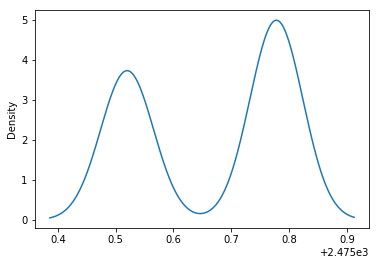

In [215]:
(time_split_sel_clusters['678b']['time'] / 86400).plot(kind='density')

In [229]:
to_plot = list(set(to_plot) - {'sa_592', 'sa_646', 'sa_765'})

I realized at this point that I had forgotten to check how large the clusters were before being split.  I felt that this lack of knowledge may have led me to believe that the bimodality I saw earlier was incorrect.

In [227]:
sel_lengths = {}
for key in list(sel.index):
    sel_lengths[key] = len(sel_clusters[key])
for key, val in sorted(sel_lengths.items(), key=lambda a: a[1]):
    print(str(key) + ": " + str(val))

sa_593: 100
sa_629: 103
sa_704: 105
sa_157: 109
sa_646: 113
sa_592: 113
sa_586: 115
sa_611: 118
sa_585: 119
sa_556: 122
sa_542: 123
sa_607: 131
sa_705: 131
sa_768: 135
sa_622: 141
sa_737: 146
sa_587: 148
sa_295: 149
sa_150: 150
sa_734: 155
sa_571: 156
sa_637: 160
sa_636: 162
sa_667: 170
sa_772: 181
sa_493: 194
sa_446: 196
sa_776: 200
sa_339: 211
sa_771: 228
sa_158: 236
sa_738: 265
sa_683: 272
sa_606: 275
sa_736: 280
sa_476: 312
sa_678: 357
sa_756: 358
sa_630: 383
sa_564: 454
sa_775: 515
sa_716: 1086


These subsequent cells contain the code that scaled the time stamps of each cluster down (or up) to meet the mean time range and created the ultimate dataset `fab`.  This second iteration of the clusters covered, on average, only 7 hours.  Moreover, not all of the clusters had the same number of points.  My solution to this was to choose a number of points smaller than the smallest cluster (I chose 14, smaller than the smallest, 47).  I would then randomly sample and interpolate the points at consistent intervals, repeating the process however many times would be necessary to "cover" the original cluster (i.e. `len(df) // 14`).  I originally tried this process with the first, non-time divided iteration because it seemed more in the spirit of the larger project to cover a larger time.  Seven hours just seemed too small.  But then, much to my dismay, when I used these larger datasets, the interpolation would consistently turn up uniform arrays (all the same number!).  I can confirm that it was not a bug.  It must have been the case that the data was, in fact, so sparse over such a long period, that all ten of the evenly spaced 50 points I was attempting to work with fell between the same ground-truth points.  This seems implausible, but it is the only explanation.  This forced me to turn to the 7-hour on average second iteration.  Though each cluster was much smaller, so the ultimate dimensionality would be much lower, the interpolations rarely all turned out with the same number.  Indeed, they looked quite varied and interesting.  

In [270]:
clusters_rec   = {key: value.drop(columns=['lat','lon','label']) for key, value in clusters.items() if key in to_plot}

In [296]:
sum_ = []
for val in time_split_sel_clusters.values():
    sum_.append(((val['time'].max() - val['time'].min())))
sum_ = np.array(sum_)
print(sum_)
sum_.mean()

[680960   7691   6190   8625  10468   9124  10846  10355  12007  11354
  13016  13050  15135  13943  16063  15084  17188  15361  17510  15825
  18020  16467  18877  17209  19695  17541  20093  17825  20457  18688
  21359  20100  22747  23224  25759  24223  26758  24814  27565  25662
  28595    488    322   1274    331    337    295    452    357    785
    503    327    562  30671    572  14767  15545  16500  27181   3005
  25401   2925   1116    879]


23751.0625

In [298]:
# Just checking
print(sorted([(cluster['time'].max() - cluster['time'].min()) for cluster in time_split_sel_clusters.values()]))

[23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0, 23751.0]


In [297]:
for cluster in time_split_sel_clusters.values():
    cluster.loc[:, 'time'] = cluster['time'] * (23751 / (cluster['time'].max() - cluster['time'].min()))
    cluster.loc[:, 'time'] = cluster['time'] - cluster['time'].min()

/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [309]:
interpolants = [j * 1697 for j in range(1, 15)]
fab = pd.DataFrame({'time': interpolants})
for name, cluster in time_split_sel_clusters.items():
    n_samples = len(cluster) // 14
    for i in range(n_samples):
        temp = cluster.sample(n=10, random_state=i)
        temp.sort_values(by='time', inplace=True)
        interpolated = np.interp(interpolants, temp['time'].values, temp['val'].values)
        fab.insert(len(fab.columns), '%s-%s' % (name, i+1), interpolated)
fab.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/final.parquet', engine='fastparquet', compression=None)

Though I followed through all the way to the end of the data preparation for the sake of illustration, this path actually represented a significant sacrifice.  After being pleasantly surprised by hdbscan's performance on ~300,000 points, I hoped that it would scale if not to the largest bins of 20-30 millionq then at least to the Africa, which had only 500,000 more points.  Alas hdbscan was not done fitting almost six hours later despite an advantageous choice of the `algorithm` parameter; a rate at which it was not worth pursuing.  It might have gone faster had it been possible to use the even more appropriate `prims_kdtree` as the `algorithm`.  The k-dimensional tree is a better investment for low dimensionality; I don't know how much overhead the ball tree actually imposed when higher dimensions were not requested.  `prims_kdtree` could not be used because like its predecessor implementation, `sklearn.neighbors.KDTree`, it does not support the use of Haversine distance.  Perhaps with better visualization tools, we could have done enough geographic narrowing to discard this requirement and allow more flat-earth approximation.  

In [ ]:
africa = pd.read_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/africa/africa.parquet', engine='fastparquet')
africa_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=-1,
                                   algorithm='prims_balltree')
africa_clusterer.fit(np.radians(africa[['lat', 'lon']].values))
dump(africa_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/africa-clustering-1.pkl')

### Clustering [AS IT SHOULD BE DONE]

---

The title is a little facetious.  These steps very much represent a compromise on my original plan; this box more serves to show what from the clustering section executed.  This is a standalone executable cell that accomplishes the clustering task.  I repeat the code from the last [AS IT SHOULD BE DONE] section for continuity:

In [ ]:
mmnts = dd.read_csv('measurements-out.csv', usecols=['Captured Time', 'Latitude', 'Longitude', 'Value', 'Unit'])
mmnts = mmnts.rename(columns={'Captured Time': 'Time'})
mmnts = mmnts.repartition(npartitions=(6*cpu_count()))
mmnts = mmnts.dropna()
with dask.config.set(scheduler='processes'):
    mmnts = mmnts.categorize(columns=['Unit'], index=False)
cpms = []
for category in mmnts['Unit'].cat.categories:
    if category.lower().strip() == 'cpm':
        cpms.append(category)
mmnts = mmnts[mmnts['Unit'].isin(cpms)]

start_dt = datetime.strptime('2011-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
microseconds = compile('\.\d*')

def tconv(s):
    dt = datetime.strptime(microseconds.sub('', str(s)), '%Y-%m-%d %H:%M:%S')
    delta = dt - start_dt
    result = np.array(delta.total_seconds())
    return result.astype(np.int64)

mmnts['Time'] = mmnts['Time'].apply(tconv, axis=1, meta=('Time', 'int64'))
mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
rem = mmnts_out[:-2]
rem.rename(columns={'Time':'time', 'Latitude':'lat', 'Longitude':'lon', 'Value':'val'}, inplace=True)

south_america = rem[((-90 < rem['lon']) & (rem['lon'] < -25)) 
                      & 
                    ((-60 < rem['lat']) & (rem['lat'] < 15))]

sa_hdbscan = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=-1)
sa_hdbscan.fit(np.radians(south_america[['lat', 'lon']].values))

dump(sa_hdbscan, '/path/to/pickle.pkl')

sa_cluster_data = pd.DataFrame({'label':sa_hdbscan.labels_, 'prob':sa_hdbscan.probabilities_})

south_america.reset_index(drop=True, inplace=True)

sa_plus = south_america.join(sa_cluster_data, how='inner')
sa_plus = sa_plus[sa_plus['label'] != -1]

total = sa_plus['prob'].sum()
sa_plus.sort_values(by='prob', ascending=False, inplace=True)
sa_plus.loc[:, 'prob'] = sa_plus['prob'].cumsum()
sa_plus.loc[:, 'prob'] = sa_plus['prob'] / total
sa_plus = sa_plus[sa_plus['prob'] < 0.9]

num_labels = sa_plus['label'].max() + 1
clusters, timespans = {}, {}
name = "sa_%s"
for i in range(num_labels):
    clusters[name % i]  = sa_plus[sa_plus['label'] == i]
    timespans[name % i] = ((clusters[name % i]['time'].max() - clusters[name % i]['time'].min()) / 86400) 
    
tspan = pd.Series(list(timespans.values()), index=list(timespans.keys()))
sel = tspan[(tspan > 190) & (tspan < 300)]
sel_clusters = {key: val for key, val in clusters.items() if key in list(sel.index)}

sc = sel_clusters
time_split_sel_clusters = {
    '295a': sc['sa_295'][(sc['sa_295']['time'] / 86400) < 2380],
    '734a': sc['sa_734'][(sc['sa_734']['time'] / 86400) <= 2375],
    '734b': sc['sa_734'][(sc['sa_734']['time'] / 86400) > 2375],
    '611a': sc['sa_611'][(sc['sa_611']['time'] / 86400) <= 2378],
    '611b': sc['sa_611'][(sc['sa_611']['time'] / 86400) > 2378],
    '587a': sc['sa_587'][(sc['sa_587']['time'] / 86400) <= 2378],
    '587b': sc['sa_587'][(sc['sa_587']['time'] / 86400) > 2378],
    '564a': sc['sa_564'][(sc['sa_564']['time'] / 86400) <= 2376],
    '564b': sc['sa_564'][(sc['sa_564']['time'] / 86400) > 2376],
    '493a': sc['sa_493'][(sc['sa_493']['time'] / 86400) <= 2376],
    '493b': sc['sa_493'][(sc['sa_493']['time'] / 86400) > 2376],
    '446a': sc['sa_446'][(sc['sa_446']['time'] / 86400) <= 2376],
    '446b': sc['sa_446'][(sc['sa_446']['time'] / 86400) > 2376],
    '571a': sc['sa_571'][(sc['sa_571']['time'] / 86400) <= 2377],
    '571b': sc['sa_571'][(sc['sa_571']['time'] / 86400) > 2377],
    '630a': sc['sa_630'][(sc['sa_630']['time'] / 86400) <= 2376],
    '630b': sc['sa_630'][(sc['sa_630']['time'] / 86400) > 2376],
    '629a': sc['sa_629'][(sc['sa_629']['time'] / 86400) <= 2376],
    '629b': sc['sa_629'][(sc['sa_629']['time'] / 86400) > 2376],
    '636a': sc['sa_636'][(sc['sa_636']['time'] / 86400) <= 2377],
    '636b': sc['sa_636'][(sc['sa_636']['time'] / 86400) > 2377],
    '637a': sc['sa_637'][(sc['sa_637']['time'] / 86400) <= 2372],
    '637b': sc['sa_637'][(sc['sa_637']['time'] / 86400) > 2372],
    '667a': sc['sa_667'][(sc['sa_667']['time'] / 86400) <= 2375],
    '667b': sc['sa_667'][(sc['sa_667']['time'] / 86400) > 2375],
    '705a': sc['sa_705'][(sc['sa_705']['time'] / 86400) <= 2374],
    '705b': sc['sa_705'][(sc['sa_705']['time'] / 86400) > 2374],
    '704a': sc['sa_704'][(sc['sa_704']['time'] / 86400) <= 2375],
    '704b': sc['sa_704'][(sc['sa_704']['time'] / 86400) > 2375],
    '683a': sc['sa_683'][(sc['sa_683']['time'] / 86400) <= 2378],
    '683b': sc['sa_683'][(sc['sa_683']['time'] / 86400) > 2378],
    '678a': sc['sa_678'][(sc['sa_678']['time'] / 86400) <= 2380],
    '678b': sc['sa_678'][(sc['sa_678']['time'] / 86400) > 2380],
    '716a': sc['sa_716'][(sc['sa_716']['time'] / 86400) <= 2380],
    '716b': sc['sa_716'][(sc['sa_716']['time'] / 86400) > 2380],
    '738a': sc['sa_738'][(sc['sa_738']['time'] / 86400) <= 2377],
    '738b': sc['sa_738'][(sc['sa_738']['time'] / 86400) > 2377],
    '737a': sc['sa_737'][(sc['sa_737']['time'] / 86400) <= 2371],
    '737b': sc['sa_737'][(sc['sa_737']['time'] / 86400) > 2371],
    '736a': sc['sa_736'][(sc['sa_736']['time'] / 86400) <= 2375],
    '736b': sc['sa_736'][(sc['sa_736']['time'] / 86400) > 2375],
    '622b': sc['sa_622'][(sc['sa_622']['time'] / 86400) > 2580],
    '556b': sc['sa_556'][(sc['sa_556']['time'] / 86400) > 2580],
    '606a': sc['sa_606'][(sc['sa_606']['time'] / 86400) <= 2580],
    '607a': sc['sa_607'][(sc['sa_607']['time'] / 86400) <= 2581],
    '607b': sc['sa_607'][(sc['sa_607']['time'] / 86400) > 2581],
    '586a': sc['sa_586'][(sc['sa_586']['time'] / 86400) <= 2567],
    '585b': sc['sa_585'][(sc['sa_585']['time'] / 86400) > 2567],
    '157b': sc['sa_157'][(sc['sa_157']['time'] / 86400) > 2572],
    '636a': sc['sa_636'][(sc['sa_636']['time'] / 86400) <= 2377],
    '636b': sc['sa_636'][(sc['sa_636']['time'] / 86400) > 2377],
    '158b': sc['sa_158'][(sc['sa_158']['time'] / 86400) > 2573],
    '150b': sc['sa_150'][(sc['sa_150']['time'] / 86400) > 2571.5],
    '593b': sc['sa_593'][(sc['sa_593']['time'] / 86400) > 2570],
    '646b': sc['sa_646'][(sc['sa_646']['time'] / 86400) > 2550],
    '542b': sc['sa_542'][(sc['sa_542']['time'] / 86400) > 2575],
    '771a': sc['sa_771'][(sc['sa_771']['time'] / 86400) <= 2571],
    '771b': sc['sa_771'][(sc['sa_771']['time'] / 86400) > 2571],
    '772b': sc['sa_772'][(sc['sa_772']['time'] / 86400) > 2575],
    '768a': sc['sa_768'][(sc['sa_768']['time'] / 86400) <= 2575],
    '775a': sc['sa_775'][(sc['sa_775']['time'] / 86400) <= 2575],
    '775b': sc['sa_775'][(sc['sa_775']['time'] / 86400) > 2575],
    '776a': sc['sa_776'][(sc['sa_776']['time'] / 86400) <= 2577],
    '776b': sc['sa_776'][(sc['sa_776']['time'] / 86400) > 2577],
    '476b': sc['sa_476'][(sc['sa_476']['time'] / 86400) > 2565],
    '339b': sc['sa_339'][(sc['sa_339']['time'] / 86400) > 2570],
}

sum_ = []
for val in time_split_sel_clusters.values():
    sum_.append(((val['time'].max() - val['time'].min())))
sum_ = np.array(sum_)

for cluster in time_split_sel_clusters.values():
    cluster.loc[:, 'time'] = cluster['time'] * (math.floor(sum_.mean()) / (cluster['time'].max() - cluster['time'].min()))
    cluster.loc[:, 'time'] = cluster['time'] - cluster['time'].min()
    
interpolants = [j * 1697 for j in range(1, 15)]
fab = pd.DataFrame({'time': interpolants})
for name, cluster in time_split_sel_clusters.items():
    n_samples = len(cluster) // 14
    for i in range(n_samples):
        temp = cluster.sample(n=10, random_state=i)
        temp.sort_values(by='time', inplace=True)
        interpolated = np.interp(interpolants, temp['time'].values, temp['val'].values)
        fab.insert(len(fab.columns), '%s-%s' % (name, i+1), interpolated)
fab.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/final.parquet', engine='fastparquet', compression=None)
fab # just to give a taste:) 

Grim, huh?

And it would have been even bigger had I been able to use more of the dataset, of course then I wouldn't have been able to rely on so much visual inspection.  I might have even had to try an architecture that didn't require me to have discrete and consistent dimensionality in order to handle the inconsistency of the data--which only would have grown with scale.